In [108]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE
import matplotlib.pyplot as plt

In [97]:
%store -r correlative_factors

In [98]:
correlative_factors.pop('saleprice', None)

In [99]:
# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')

# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 100)

In [100]:
drop_cols = []
for col in house_train.columns:
    if house_train[col].isnull().sum() > 0:
        drop_cols.append(col)

In [142]:
house_train[correlative_factors.keys()]

house_train['lot_area'] = np.log(house_train.lot_area)

In [150]:
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# FEATURES  = ['totrms_abvgrd', 'garage_cars', '1st_flr_sf', 'gr_liv_area', 
    #   'garage_area', 'overall_qual', 'exter_qual', 'bsmt_qual', 'kitchen_qual']

FEATURES = [x for x in correlative_factors.keys() if x not in drop_cols]
# # 
# for x in correlative_factors.keys():
#     if x not in drop_cols:
#         FEATURES.append(x)


X = house_train[FEATURES]
y = house_train.saleprice

# X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)


ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())


mlr = LassoCV(alphas = np.arange(0.001, 10, 1))
# mlr = Ridge()
# mlr = Lasso()
# mlr = LinearRegression()
# train it

scores_1 = (cross_val_score(mlr, X_train, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
# cross val score
scores_1.mean()

0.8148854792281324

In [141]:
#calculate residuals by creating predictions
mlr.fit(X_train,y_train)
preds = mlr.predict(X_train)
resid = y_train - preds

In [151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# vif

c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [104]:

squashed_columns = []
for idx, item in enumerate(mlr.coef_):
    if item == 0:
        squashed_columns.append(idx)
    
squashed_columns
Xs_train.iloc[:,squashed_columns].columns

Index([], dtype='object')

In [124]:
mlr.score(X_val, y_val)

0.8791261617228333

In [125]:
from sklearn.metrics import mean_squared_error
mean_squared_error(preds, y_train, squared = False)

30461.45880247231

Text(0.5, 1.0, 'Predicted vs. Actual')

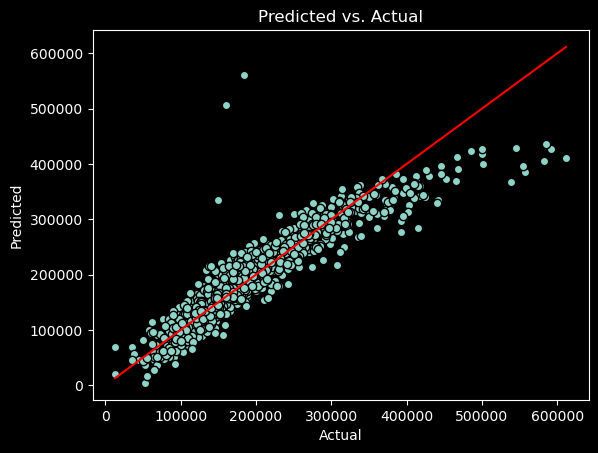

In [126]:
fig, ax = plt.subplots()
ax.scatter(y_train, preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],'r')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')

In [ ]:
sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

In [ ]:
X_sm = sm.add_constant(X_val)

res = sm.OLS(y_val, X_sm).fit()

res.summary()

In [ ]:

sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot');

In [ ]:
#E instantiate lasso with best alpha 

# mlr_test = LinearRegression()

# mlr_test.fit(Xs_train, y_train)

# ss = StandardScaler()
# Xs_test = ss.fit_transform(X_test)
# Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())



price_preds = mlr.predict(X_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [ ]:
house_test[['id', 'SalePrice']]